In [19]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import random
import matplotlib.pyplot as plt

In [10]:
# Load the dataset
df_raw = pd.read_csv('./data/train_with_dummies.csv', index_col=[0])

# Specify prefixes of columns to drop
prefixes_to_drop = ['Id', 'SaleType', 'SaleCondition', 'SalePrice']

# Drop specified columns before imputation
df_filtered = df_raw.drop([col for col in df_raw.columns if any(col.startswith(prefix) for prefix in prefixes_to_drop)], axis=1)

# Impute missing values in the filtered dataset
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

# Extract the SalePrice column from the original dataset for use as the target variable
sale_price_col = df_raw['SalePrice']
sale_price_mean = np.mean(sale_price_col)

# Scale the imputed dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(scaled_data, columns=df_imputed.columns)

# Define data_x and data_y for model input
data_x = df_scaled
data_y = sale_price_col.reset_index(drop=True)  # Reset index to ensure alignment

In [11]:
data_x.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,-0.037037,-0.045376,-0.205214,-0.195977,-0.347118,-0.087129,-0.037037,-0.037037,-0.186352,-0.02618
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,-0.037037,-0.045376,-0.205214,-0.195977,-0.347118,-0.087129,-0.037037,-0.037037,-0.186352,-0.02618
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,-0.037037,-0.045376,-0.205214,-0.195977,-0.347118,-0.087129,-0.037037,-0.037037,-0.186352,-0.02618
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,-0.037037,-0.045376,-0.205214,-0.195977,-0.347118,-0.087129,-0.037037,-0.037037,-0.186352,-0.02618
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,-0.037037,-0.045376,-0.205214,-0.195977,-0.347118,-0.087129,-0.037037,-0.037037,-0.186352,-0.02618


In [12]:
class QLearningAgent:
    def __init__(self, state_space_size, action_space_size, learning_rate, discount_rate, exploration_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.q_table = np.zeros((state_space_size, action_space_size))
        

    def choose_action(self, state):
        valid_actions = [i for i in range(self.action_space_size) if state[i] == 0]
        if np.random.uniform(0, 1) < self.exploration_rate:
            action = np.random.choice(valid_actions)
        else:
            q_values = np.array([self.q_table[state, a] if a in valid_actions else -np.inf for a in range(self.action_space_size)])
            print("Qvalues ", q_values)
            action = np.argmax(q_values)
            
            
        return action


    def update_q_table(self, state, action, reward, next_state):
        next_max = np.max(self.q_table[next_state, :])
        print("Q_table entry", self.q_table[state, action])
        self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (reward + self.discount_rate * next_max - self.q_table[state, action])

    def decay_exploration_rate(self):
        self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate)

In [13]:
def create_model(input_dim, output_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    
    target_model = models.clone_model(model)
    target_model.set_weights(model.get_weights())
    
    return model, target_model




class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = batch_size
        self.model, self.target_model = create_model(state_size, action_size)


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Perform a random action, but only consider valid actions
            valid_actions = [i for i, val in enumerate(state[0]) if val == 0]
            return np.random.choice(valid_actions)
        else:
            act_values = self.model.predict(state, verbose=0)
            # Mask out invalid actions by setting their Q-values to a large negative number
            act_values[0][state[0] == 1] = -1e9
            return np.argmax(act_values[0])  # returns action

        
    def replay(self):
        minibatch = random.sample(self.memory, self.batch_size)
        states = []
        next_states = []
        for state, action, reward, next_state, done in minibatch:
            # Reshape state and next_state without the extra singleton dimension
            state = np.squeeze(state)  # Remove the extra singleton dimension
            next_state = np.squeeze(next_state)  # Remove the extra singleton dimension
            states.append(state)
            next_states.append(next_state)
        states = np.array(states)
        next_states = np.array(next_states)
        current_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(next_q_values[i]))
            current_q_values[i][action] = target

        # Set verbose=0 to hide progress bars
        self.model.fit(states, current_q_values, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [14]:
class FeatureSelectionEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_features, data_x, data_y, error_metric='rmse', debug=False):
        super(FeatureSelectionEnv, self).__init__()
        self.num_features = num_features
        self.data_x = data_x
        self.data_y = data_y
        self.sale_price_mean = 180921.19
        self.action_space = spaces.Discrete(num_features + 1)  # Action: select a feature to toggle or END
        self.observation_space = spaces.MultiBinary(num_features + 1)  # State: binary vector of selected features
        self.state = None
        
        self.debug = debug
        
        self.error_metric = error_metric
        if self.error_metric == 'rmse':
            self.scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
        else:
            raise ValueError("Unsupported error metric")
        self.num_cvs = 5

        self.previous_error = self.get_initial_error()

        
    def get_initial_error(self):
        predictions = np.full(self.data_y.shape, self.sale_price_mean)

        # print(self.data_y, predictions)
        if self.error_metric == 'rmse':
            initial_error = mean_squared_error(self.data_y, predictions, squared=False)
        else:
            initial_error = 0

        return initial_error


    def reset(self):
        self.state = np.zeros(self.num_features + 1
                              , dtype=np.int8)  # Start with no features selected
        
        self.previous_error = self.get_initial_error()
        
        # print(self.previous_error, "RESET ERROR")
        return self.state

    def step(self, action):
        done = False
        reward = 0
        all_features_selected = all(self.state[:-1])
        if action == self.num_features or all_features_selected:
            # Action is to end the sequence
            done = True
            reward = self.evaluate_reward()
            
#             if action == self.num_features:
#                 reward += 100000
            # Adding bonus for termination
        else:
            if self.state[action] == 0:  # Ensure action is valid (feature not already included)
                self.state[action] = 1
                reward = self.evaluate_reward()  # Optionally, evaluate reward after each feature selection
            else:
                raise ValueError("Shouldn't get to this because agent handles invalid action")
        
        if reward == -1000:
            done = True
        info = {}
        return self.state, reward, done, info


    def render(self, mode='human', close=False):
        pass

    def evaluate_reward(self):
        selected_features_indices = [i for i, included in enumerate(self.state) if included == 1]
        
#         print(self.data_x)
#         assert all(idx < self.data_x.shape[1] for idx in selected_features_indices), "One or more selected feature indices are out of bounds"

        X_selected = self.data_x.iloc[:, selected_features_indices]

        model = LinearRegression()

        # Use self.scorer for cross-validation
        scores = cross_val_score(model, X_selected, self.data_y, scoring=self.scorer, cv=self.num_cvs)
        current_error = -np.mean(scores)  # Assuming self.scorer is a 'neg_' metric for minimization
        
        # print(self.previous_error, current_error)
        reward = self.previous_error - current_error
        
        # print(reward, self.previoaus_error, current_error)
        self.previous_error = current_error
        
        if current_error > 500000:
            reward = -1000
        
        if self.debug:
            print(reward)
        return reward

In [24]:
env = FeatureSelectionEnv(num_features=273, data_x=data_x, data_y=data_y, error_metric='rmse')
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n, 32)

In [ ]:
NUM_EPISODES = 1000  # Number of episodes to run
batch_size = 32
total_rewards_list = []  # List to store total rewards for each episode

for e in range(NUM_EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    total_reward = 0  # Initialize total reward for the episode

    for time in range(500):  # Assuming a max timestep per episode
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward  # Accumulate reward
        next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode: {e+1}, Total reward: {total_reward}, Exploration Rate: {agent.epsilon}")  # Print total reward
            total_rewards_list.append(total_reward)  # Append total reward to the list
            break
    
    if e > 0:
        agent.replay()

# Plotting total rewards
import matplotlib.pyplot as plt

plt.plot(total_rewards_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()


Episode: 1, Total reward: 23930.919106617548, Exploration Rate: 1.0
Episode: 2, Total reward: 8224.927002769953, Exploration Rate: 1.0
Episode: 3, Total reward: 29077.187030185436, Exploration Rate: 0.995
Episode: 4, Total reward: 29503.234403541697, Exploration Rate: 0.990025
Episode: 5, Total reward: 20040.783818968906, Exploration Rate: 0.985074875
Episode: 6, Total reward: 37185.03917845678, Exploration Rate: 0.9801495006250001
Episode: 7, Total reward: 29624.97065754574, Exploration Rate: 0.9752487531218751
Episode: 8, Total reward: 28462.797707416335, Exploration Rate: 0.9703725093562657
Episode: 9, Total reward: 23416.03047545821, Exploration Rate: 0.9655206468094844
Episode: 10, Total reward: 29097.400759047487, Exploration Rate: 0.960693043575437
Episode: 11, Total reward: 14361.439950376167, Exploration Rate: 0.9558895783575597
Episode: 12, Total reward: 18225.39334643846, Exploration Rate: 0.9511101304657719
Episode: 13, Total reward: 32235.098761240522, Exploration Rate: 0.

Episode: 101, Total reward: 42334.54967233603, Exploration Rate: 0.6088145090359074
Episode: 102, Total reward: 44830.910434549136, Exploration Rate: 0.6057704364907278
Episode: 103, Total reward: 44799.82217135915, Exploration Rate: 0.6027415843082742
Episode: 104, Total reward: 44715.579188959695, Exploration Rate: 0.5997278763867329
Episode: 105, Total reward: 43989.30933506979, Exploration Rate: 0.5967292370047992
Episode: 106, Total reward: 43566.01872558102, Exploration Rate: 0.5937455908197752
Episode: 107, Total reward: 40596.279817988834, Exploration Rate: 0.5907768628656763
Episode: 108, Total reward: 44631.04063896383, Exploration Rate: 0.5878229785513479
Episode: 109, Total reward: 44769.66968181042, Exploration Rate: 0.5848838636585911
Episode: 110, Total reward: 45290.28628142143, Exploration Rate: 0.5819594443402982
Episode: 111, Total reward: 44022.22586892483, Exploration Rate: 0.5790496471185967
Episode: 112, Total reward: 45232.59273803067, Exploration Rate: 0.576154

Episode: 199, Total reward: 32790.14759022843, Exploration Rate: 0.37251769488706843
Episode: 200, Total reward: 45962.728224481965, Exploration Rate: 0.3706551064126331
Episode: 201, Total reward: 48366.38944927406, Exploration Rate: 0.36880183088056995
Episode: 202, Total reward: 47507.2995123782, Exploration Rate: 0.3669578217261671
Episode: 203, Total reward: 47863.984580677235, Exploration Rate: 0.36512303261753626
Episode: 204, Total reward: 46605.12155611709, Exploration Rate: 0.3632974174544486
Episode: 205, Total reward: 47624.179662610746, Exploration Rate: 0.3614809303671764
Episode: 206, Total reward: 46524.185798797334, Exploration Rate: 0.3596735257153405
Episode: 207, Total reward: 47328.39543257594, Exploration Rate: 0.3578751580867638
Episode: 208, Total reward: 47494.5712576802, Exploration Rate: 0.35608578229633
Episode: 209, Total reward: 48460.549404720936, Exploration Rate: 0.3543053533848483
Episode: 210, Total reward: 46904.86402490825, Exploration Rate: 0.35253

Episode: 296, Total reward: 48094.28017126403, Exploration Rate: 0.2290792429684691
Episode: 297, Total reward: 48635.4784715309, Exploration Rate: 0.22793384675362674
Episode: 298, Total reward: 48852.29323458866, Exploration Rate: 0.22679417751985861
Episode: 299, Total reward: 48852.58629140559, Exploration Rate: 0.22566020663225933
Episode: 300, Total reward: 47853.528754073384, Exploration Rate: 0.22453190559909803
Episode: 301, Total reward: 48902.662540108984, Exploration Rate: 0.22340924607110255
Episode: 302, Total reward: 48625.737274348285, Exploration Rate: 0.22229219984074702
Episode: 303, Total reward: 49057.35373227368, Exploration Rate: 0.2211807388415433
Episode: 304, Total reward: 49014.800534298585, Exploration Rate: 0.22007483514733558
Episode: 305, Total reward: 48701.78161293808, Exploration Rate: 0.2189744609715989
Episode: 306, Total reward: 49134.0133555587, Exploration Rate: 0.2178795886667409
Episode: 307, Total reward: 49577.0526836068, Exploration Rate: 0.2

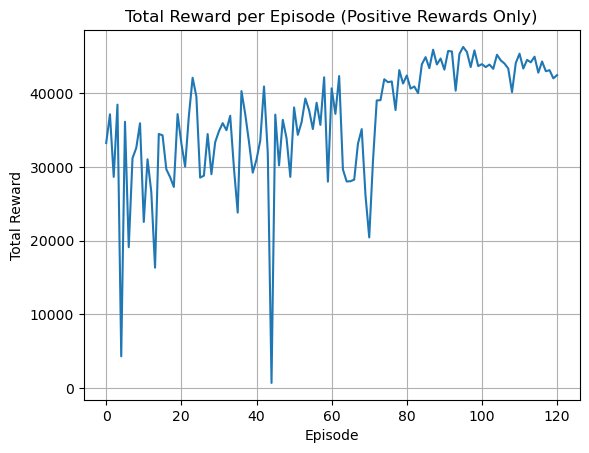

In [21]:
import matplotlib.pyplot as plt

# Filter out rewards that are 0 or less
filtered_rewards = [reward for reward in total_rewards_list if reward > 0]

plt.plot(filtered_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Positive Rewards Only)')
plt.grid(True)
plt.show()

In [22]:
for e in range(1):
    state = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    total_reward = 0  # Initialize total reward for the episode

    for time in range(500):  # Assuming a max timestep per episode
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward  # Accumulate reward
        next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode: {e+1}, Total reward: {total_reward}")  # Print total reward
            total_rewards_list.append(total_reward)  # Append total reward to the list
            break

print(env.state)

Episode: 1, Total reward: 42638.25031884726
[0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0
 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [23]:
for i, included in enumerate(env.state):
    if included == 1:
        print("Selected column:", data_x.columns[i])

Selected column: LotFrontage
Selected column: LotArea
Selected column: OverallQual
Selected column: BsmtFinSF1
Selected column: TotalBsmtSF
Selected column: 2ndFlrSF
Selected column: GrLivArea
Selected column: FullBath
Selected column: HalfBath
Selected column: TotRmsAbvGrd
Selected column: GarageCars
Selected column: GarageArea
Selected column: 3SsnPorch
Selected column: ScreenPorch
Selected column: MoSold
Selected column: MSZoning_RL
Selected column: LotShape_IR2
Selected column: LotShape_Reg
Selected column: LandContour_Low
Selected column: Neighborhood_NAmes
Selected column: Neighborhood_NridgHt
Selected column: Neighborhood_SawyerW
Selected column: Condition1_RRNn
Selected column: Condition2_PosN
Selected column: Condition2_RRNn
Selected column: BldgType_Duplex
Selected column: BldgType_Twnhs
Selected column: HouseStyle_1Story
Selected column: HouseStyle_2.5Unf
Selected column: RoofStyle_Flat
Selected column: RoofMatl_Metal
Selected column: Exterior1st_Plywood
Selected column: Ext